In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
import astropy.constants as const
from scipy.stats import permutation_test
import kcorrect.kcorrect
from astroquery.sdss import SDSS

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathptmx}",  # Times Roman
    "hatch.linewidth": 3.0,
})
sns.set_context("paper",font_scale=1)
sns.set_palette("pastel")

In [ ]:
def query_liu_specobj(liudf):
    """used 1 time to search liu in specobj
        Note that 26 AGN in liu did not have a specObj match, 
        can get index of these by merge catalog search res with liudf"""
    plates = liudf.Plate
    mjds = liudf.MJD
    fibers = liudf.Fiber
    res = []
    miss = []
    for i in range(len(plates)):
        try:
            r = SDSS.query_specobj(plate = plates[i], mjd = mjds[i], fiberID=fibers[i], fields=['ra','dec','z','plate','fiberid','mjd',
                                                                'spectroFlux_u','spectroFluxIvar_u',
                                                                'spectroFlux_g','spectroFluxIvar_g',
                                                                'spectroFlux_z','spectroFluxIvar_z',
                                                                'spectroFlux_r','spectroFluxIvar_r',
                                                                'spectroFlux_i','spectroFluxIvar_i']).to_pandas()
            res.append(r)
        except:
            print(i)
            miss.append(i)


def liu_lum(df):
    """calculate luminosity in r-band"""
    flx = 10**((22.5-df.rmag.values)/2.5)*3.631e-6*u.Jy
    nu = const.c/6231/u.angstrom
    lum = (4*np.pi*(flx*nu)*cosmo.luminosity_distance(df.z.values)**2).to(u.erg/u.s)
    return lum.value


# total luminosity per system after upsampling
def callum_upsamp(upsamp_lum):
    upsamp_Ltot = []
    for i in range(0,len(upsamp_lum)-1,2):
        upsamp_Ltot.append(upsamp_lum[i]+upsamp_lum[i+1])
    return upsamp_Ltot

In [22]:
# open data 
with open("/home/insepien/research-data/df/liuO.txt", "r") as f:
    liu = [a.rstrip().replace("   "," ").replace("  ", " ").split(" ") for a in f.readlines()[37:]]
liudf = pd.DataFrame(liu[1:],columns=liu[0]) 
# convert to float
liudf[liudf.columns[1:]] = liudf[liudf.columns[1:]].astype(float)
# add absolute mag (not k-corrected but has accounted for extinction)
# liudf['absmag'] = liudf.rmag.values - 5 * np.log10(cosmo.luminosity_distance(liudf.z.values).to(u.pc).value/10) + 2.5*np.log10(1+liudf.z)
# add r-band lum
# liudf['lum-r'] = liu_lum(liudf)

# sep = liudf['rp'].values.astype(float)
# mag = liudf['rmag'].values.astype(float)
# redshifts = liudf['z'].astype(float).values

# need to check if mag provided is AB or asinh, but lum change shouldn't be too large
# flx = 10**((22.5-liudf.rmag.values)/2.5)*3.631e-6*u.Jy
# nu = const.c/6231/u.angstrom
# lum = (4*np.pi*(flx*nu)*cosmo.angular_diameter_distance(redshifts)**2).to(u.erg/u.s)

# label multi-AGN system
n_sys = 0
liudf['pid'] = [None]*len(liudf)
i=0
# loop through df
while i < liudf.shape[0]-1:
    # if 2 consecutive rows share rp, label rows as 1 system
    if liudf.loc[i].rp == liudf.loc[i+1].rp:
        n_sys+=1
        liudf.loc[i,'pid'] = n_sys
        liudf.loc[i+1,'pid'] = n_sys
        i+=2
    # else label as 0
    else:
        liudf.loc[i,'pid'] = 0
        i+=1
print(f"Number of multi-AGN system: {(liudf.pid!=0).sum()/2}")
# Fix the mixed up rows
# get indices of misclassified rows
misclas_ind = liudf[liudf.pid==0].index.values
# search in the neighboring n rows
for n in range(1,5):
    # for each misclassified row
    for j in range(len(misclas_ind)-n):
        # classify as a system if w neighboring misclassified rows share rp
        if liudf.loc[misclas_ind[j],'rp'] == liudf.loc[misclas_ind[j+n],'rp']:
            n_sys +=1
            liudf.loc[misclas_ind[j],'pid'] = n_sys
            liudf.loc[misclas_ind[j+n],'pid'] = n_sys

print(f"Fixed # sys: {(liudf.pid!=0).sum()/2}")

# get only the pairs from liu
pairs = liudf[liudf.pid!=0]

Number of multi-AGN system: 1150.0
Fixed # sys: 1284.0


## search in sdss and crossmatch

In [15]:
# load results of sdss search for the original sample
sdss = pd.read_pickle("specobj_liu11.pkl")
sdss.rename(columns={'plate':'Plate'},inplace=True)
sdss = sdss.astype(float)
sdss.reset_index(inplace = True, drop=True)
# create id = plate-fiber-mjd to merge dfs
sdss['id'] = [f"{sdss.loc[i].Plate:.0f}-{sdss.loc[i].fiberid:.0f}-{sdss.loc[i].mjd:.0f}" for i in range(sdss.shape[0])]
liudf['id'] = [f"{liudf.loc[i].Plate:.0f}-{liudf.loc[i].Fiber:.0f}-{liudf.loc[i].MJD:.0f}" for i in range(liudf.shape[0])]
# merge pairs in liu with sdss search
liuInSpec = pairs.merge(sdss, how='left', on='id')
liuInSpec.shape

(2568, 31)

do k correction

In [16]:
responses = ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0']
kc = kcorrect.kcorrect.Kcorrect(responses=responses)

liuInSpec['absmagKcor_r'] = np.zeros(len(liuInSpec))
liuInSpec['k_r'] = np.zeros(len(liuInSpec))


for i in liuInSpec[np.isfinite(liuInSpec['spectroFluxIvar_g'])].index.values:
    # get row
    r = liuInSpec.loc[i]
    # get z, flux, error
    redshift = r.z_y
    maggies = r[['spectroFlux_u','spectroFlux_g','spectroFlux_r','spectroFlux_i','spectroFlux_z']].values*1e-9
    ivar = r[['spectroFluxIvar_u','spectroFluxIvar_g','spectroFluxIvar_r','spectroFluxIvar_i','spectroFluxIvar_z']].values 
    # "coeffs" is a [5]-array with coefficients multiplying each template
    coeffs = kc.fit_coeffs(redshift=redshift, maggies=maggies, ivar=ivar)
    # "k" is a [5]-array with the K-corrections in magnitude units
    k = kc.kcorrect(redshift=redshift, coeffs=coeffs)
    liuInSpec.loc[i,'k_r'] = k[2]
    absmag = kc.absmag(redshift=redshift, maggies=maggies, ivar=ivar, coeffs=coeffs)
    liuInSpec.loc[i,'absmagKcor_r']=absmag[2]

# for missing AGN, assuming similar magnitude as the other AGN in pair
# it is hard to find mag for these, since Liu reports ap.amg with extinction correction
# while kcorrect doesn't account for that, so there is not a straightforward way to calibrate
miss = liuInSpec[~ np.isfinite(liuInSpec['spectroFluxIvar_g'])].index
for i in miss:
    liuInSpec.loc[i,'absmagKcor_r'] = np.sum(liuInSpec[liuInSpec.pid == liuInSpec.loc[i,'pid']]['absmagKcor_r'])
# drop the 1 system where both AGN have no sdss match
liuInSpecFin = liuInSpec[~ (liuInSpec['absmagKcor_r'] == 0)]


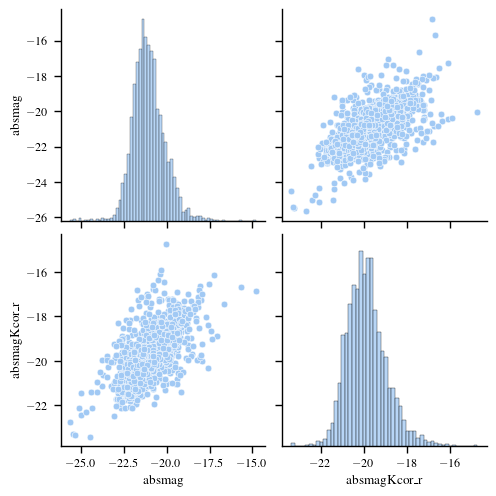

In [13]:
sns.pairplot(liuInSpec[['absmag','absmagKcor_r']])

### now upsample from only pairs with sdss match

In [ ]:
# number of systems to upsample from paper
p = 1286/138070
C = 3.3#((1+2*p)*0.3*0.99+(1+p)*(1-0.3)*0.92)/((1+2*p)*0.3*0.99**2)
n_upsamp = (C-1)*liuInSpecFin.shape[0]/2
# random upsampling from pairs with sep < 55''
smallsep_pairs = liuInSpecFin[liuInSpecFin.DelTh < 55]
np.random.seed(0)
upsamp_id = np.random.choice(list(set(smallsep_pairs.pid)),int(n_upsamp),replace=True)
upsamp_df = pd.concat([liuInSpecFin[liuInSpecFin.pid==i] for i in upsamp_id])
fulldf = pd.concat([liuInSpecFin,upsamp_df])
# # total luminosity per system
# upsamp_Ltot = callum_upsamp(fulldf['lum-r'].values)

Check to see upsampling look like paper plot

''

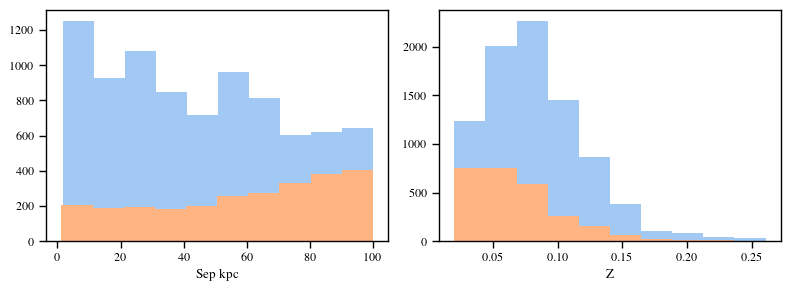

In [39]:
fig,ax = plt.subplots(1,2,figsize=(8,3))
[df.rp.hist(ax=ax[0],grid=False) for df in [fulldf,liudf]]
ax[0].set_xlabel("Sep kpc")


[df[z].hist(ax=ax[1],grid=False) for df,z in zip([fulldf,liudf],['z_x','z'])]
ax[1].set_xlabel("Z")
fig.tight_layout()
;

malmquist

''

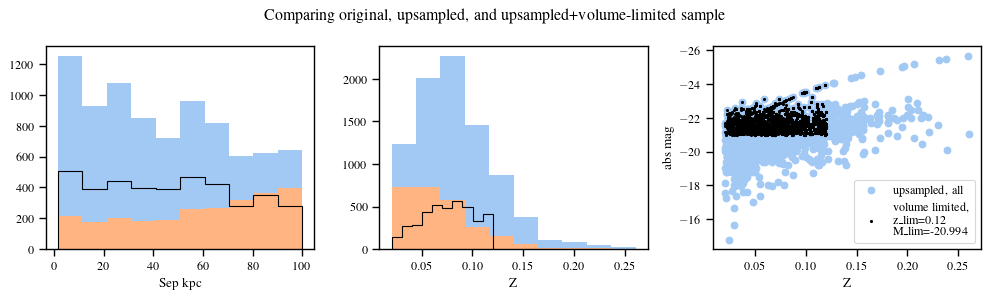

In [67]:
# Malmquist bias correction
# find Mlim(zlim, m_survey_lim)
zlim = 0.12
Mlim = 17.77 - cosmo.distmod(zlim).value
abmag_mask = (fulldf.absmag < Mlim)
zmask = fulldf.z_y < zlim
vldf = fulldf[abmag_mask & zmask]
# upsamp_Ltot_vollim = callum_upsamp(vldf['lum-r'].values)

fig,ax = plt.subplots(1,3,figsize=(10,3))
[df.rp.hist(ax=ax[0],grid=False) for df in [fulldf,liuInSpecFin]]
ax[0].hist(vldf.rp, histtype='step',color='k')
ax[0].set_xlabel("Sep kpc")

[df.z_x.hist(ax=ax[1],grid=False) for df in [fulldf,liuInSpecFin]]
ax[1].hist(vldf.z_y, histtype='step', color='k')
ax[1].set_xlabel("Z")

ax[2].scatter(liuInSpecFin.z_x, liuInSpecFin.absmag, label='upsampled, all')
ax[2].scatter(vldf.z_x, vldf.absmag,label=f'volume limited,\nz_lim={zlim}\nM_lim={Mlim:.3f}',c='k',s=2)
ax[2].set_xlabel("Z")
ax[2].set_ylabel("abs mag")
ax[2].yaxis.set_inverted(True)
ax[2].legend()

fig.suptitle("Comparing original, upsampled, and upsampled+volume-limited sample")
fig.tight_layout()
;


## measure df

/tmp/ipykernel_30585/3933156996.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vldf.rename(columns={"z_x":"z"}, inplace=True)


PermutationTestResult(statistic=-2.0, pvalue=0.5775, null_distribution=array([-1.8 ,  3.  ,  1.7 , ..., -5.75,  2.95, -3.6 ]))
0.0 0.0


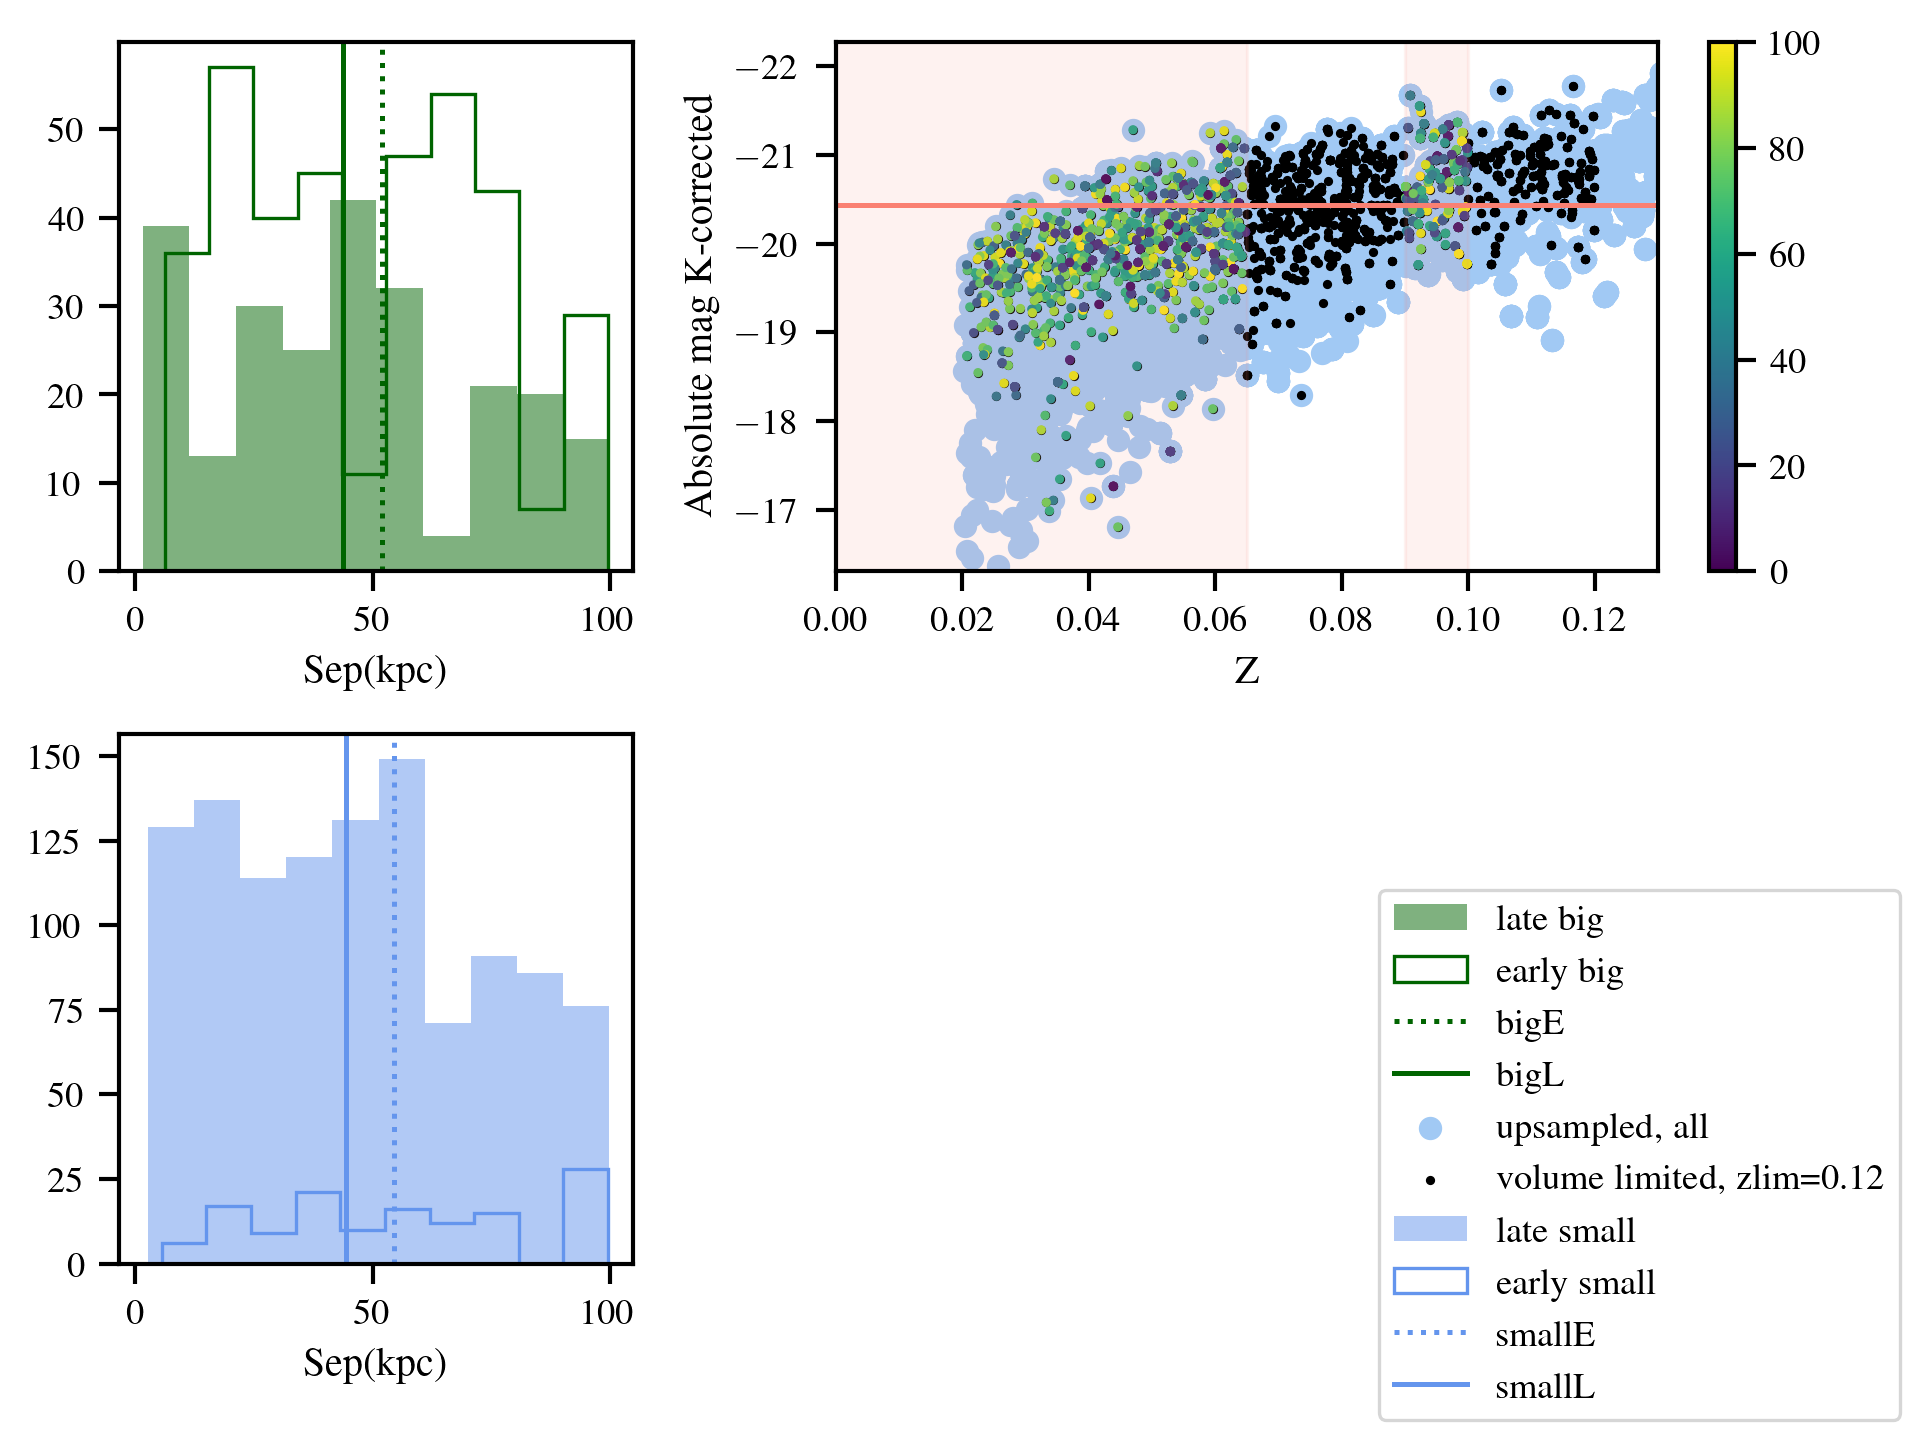

In [93]:
from scipy.stats import permutation_test
def quart_mask(quant,cuts,ismag=False):
    mask = []
    mask.append(quant<cuts[0])
    if len(cuts)!= 1:
        for i in range(len(cuts)-1):
            mask.append( ( (quant>cuts[i]) & (quant<cuts[i+1]) ) )
    mask.append(quant>cuts[-1])
    if ismag:
        return list(reversed(mask))
    else:
        return mask

def med_diff(rsmall_e,rsmall_l,rbig_e,rbig_l,axis):
    diffbigM = np.median(rbig_e,axis=axis) - np.median(rbig_l,axis=axis)
    diffsmallM = np.median(rsmall_e,axis=axis) - np.median(rsmall_l,axis=axis)
    return diffbigM - diffsmallM

# fulldf_complete  = fulldf[fulldf[]]
# loglum = vldf['lum-r']
vldf.rename(columns={"z_x":"z"}, inplace=True)
amag = vldf.absmagKcor_r
redshifts = vldf.z.values
sep = vldf.rp.values

cutsE = np.percentile(amag,[50,50])
zLate = [0, 0.065]
zEarly = [0.09, 0.1]
sepmax = 100

cutsL = cutsE
massmaskE= quart_mask(amag,cutsE,ismag=True)
massmaskL = quart_mask(amag,cutsL,ismag=True)
early = (redshifts > zEarly[0]) & (redshifts < zEarly[1])
late = (redshifts < zLate[1]) & (redshifts > zLate[0])
sepcut = sep < sepmax
smallE = massmaskE[0] & early & sepcut
smallL = massmaskL[0] & late & sepcut
bigE = massmaskE[2] & early& sepcut
bigL = massmaskL[2] & late & sepcut

bigc = 'darkgreen'
smallc = 'cornflowerblue'

fig,ax = plt.subplots(2,2,dpi=300,width_ratios=[1,2])
ax[0,0].hist(vldf.rp[bigL],label='late big',alpha=0.5,color=bigc)
ax[0,0].hist(vldf.rp[bigE],histtype='step',label='early big',color=bigc)

ax[1,0].hist(vldf.rp[smallL],label='late small',alpha=0.5,color=smallc)
ax[1,0].hist(vldf.rp[smallE],histtype='step',label='early small',color=smallc)
for x,l,ls,c,a in zip([smallE,smallL,bigE,bigL],['smallE', 'smallL', 'bigE', 'bigL'],[":","-",":","-"],[smallc,smallc,bigc,bigc],[ax[1,0],ax[1,0],ax[0,0],ax[0,0]]):
    a.axvline(np.median(vldf.rp[x]),label=l,linestyle=ls,color=c)

ax[1,0].set_xlim(ax[0,0].get_xlim())

ax[0,1].scatter(fulldf.z_x, fulldf.absmagKcor_r, label='upsampled, all')
ax[0,1].scatter(vldf.z, vldf.absmagKcor_r,label=f'volume limited, zlim={zlim}',c='k',s=2)
im = [ax[0,1].scatter(vldf.z[mask], vldf.absmagKcor_r[mask],c=vldf.rp[mask],vmin=0,vmax=sepmax,s=2) for mask in [smallE,bigE,smallL,bigL]]
ax[0,1].set_xlabel("Z")
ax[0,1].set_ylabel("Absolute mag K-corrected")
ax[0,1].yaxis.set_inverted(True)
[ax[0,1].axhline(c,c='salmon') for c in cutsE]
[ax[0,1].fill_between([c[0],c[1]],ax[0,1].get_ylim()[0],ax[0,1].get_ylim()[1],alpha=0.1,color='salmon') for c in [zLate,zEarly]]
ax[0,1].set_xlim(0,zlim+0.01)
ax[0,1].set_ylim(np.max(vldf.absmagKcor_r)+0.5,np.min(vldf.absmagKcor_r)-0.5)
fig.colorbar(im[0],ax=ax[0,1])
# ax[0,1].scatter(vldf.z[massmaskL[2] & late & sepcut], vldf.absmag[massmaskL[2] & late & sepcut], color='r')

[a.set_xlabel("Sep(kpc)") for a in ax[:,0]]
# [a.text(1,30,t,fontsize=18) for a,t in zip(ax[:,0], ['big','small'])]

fig.legend(loc='lower right')
ax[1,1].axis('off')
fig.tight_layout();

seps = [vldf.rp[m] for m in [smallE,smallL,bigE,bigL]]
print(permutation_test(seps, statistic=med_diff, vectorized=True,alternative='greater'))
print(np.median(smallE)-np.median(smallL), np.median(bigE)-np.median(bigL))

In [92]:
time = lambda z1,z2: np.log10((cosmo.comoving_volume(z1) - cosmo.comoving_volume(z2)).value)
time(0.065,0.0), time(0.1,0.09)

(7.950117201386849, 7.925933378841308)

cute viz

/home/insepien/miniconda3/envs/usc/lib/python3.11/site-packages/astropy/cosmology/flrw/base.py:1343: RuntimeWarning: divide by zero encountered in log10
  val = 5.0 * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


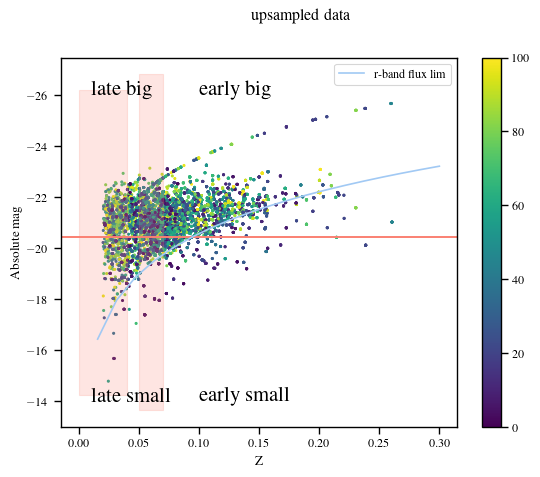

In [89]:
fig,ax = plt.subplots()
im = ax.scatter(fulldf.z_x, fulldf.absmag, c=fulldf.rp, vmin=0, vmax=100, s=2)
ax.set_xlabel("Z")
ax.set_ylabel("Absolute mag")
ax.yaxis.set_inverted(True)
[ax.axhline(c,c='salmon') for c in cutsE]
[ax.fill_between([c[0],c[1]],ax.get_ylim()[0],ax.get_ylim()[1],alpha=0.2,color='salmon') for c in [zLate,zEarly]]
ax.text(0.1,-14,"early small",fontsize=15)
ax.text(0.1,-26,"early big",fontsize=15)
ax.text(0.01,-14,"late small",fontsize=15)
ax.text(0.01,-26,"late big",fontsize=15)

zrange = np.linspace(0,0.3,20)
ax.plot(zrange, 17.77-cosmo.distmod(zrange).value, label='r-band flux lim')
ax.legend()

fig.suptitle("upsampled data")
fig.colorbar(im);

